In [212]:
#Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score

In [213]:
# Train data loading
train=pd.read_csv(r'D:\Dane\zuzoa\Desktop\Python\titanic\train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [214]:
# X test data loading
X_test_raw=pd.read_csv(r'D:\Dane\zuzoa\Desktop\Python\titanic\test.csv')
X_test_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [215]:
# y test data loading
y_test_raw=pd.read_csv(r'D:\Dane\zuzoa\Desktop\Python\titanic\gender_submission.csv')
y_test_raw.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


We need to ensure that the X test data and y test data corespond. Let's merge them with ID and split again

In [216]:
test=X_test_raw.merge(y_test_raw,how='inner',on='PassengerId')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


We cannot assume that the data prepared for this project is not biased. We can concatenate test and train data, clean, shuffle it randomly and then take the train/test probes.

In [217]:
data=pd.concat([train,test],axis=0)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [218]:
data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Data contains so much empty values in Cabin and some in Age. If the data has around 1300 values it is reasonable to:
1) drop Cabin column. 
2) check the distribution of Age. If the variance is not quite big it will be possible to approximate the 260 values with mean or if distribution will change significantly use FFILL

In [219]:
data.drop(columns='Cabin',inplace=True)

D:\Dane\zuzoa\AppData\Local\Programs\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


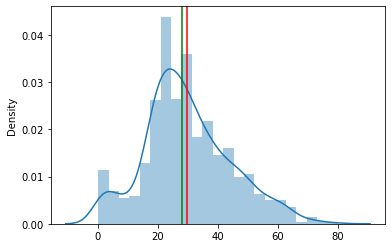

In [220]:
sns.distplot(x=data['Age'],kde=True,label='dist')
plt.axvline(data['Age'].mean(), 0,2,color='r',label='mean')
plt.axvline(data['Age'].median(), 0,2,color='g',label='median')

Looking at the histogram it is reasonable to use ffill, because the mean and median don't change significantly ( red and greed colored on the plot ) as an estimator of the data. It can be treated with Imputer, but first we can see how it will change the distribution

In [221]:
data['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

D:\Dane\zuzoa\AppData\Local\Programs\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


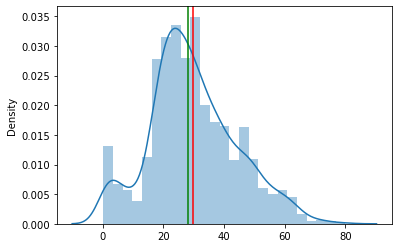

In [222]:
data['Age'].fillna(method='ffill',inplace=True)
sns.distplot(x=data['Age'],kde=True,label='dist')
plt.axvline(data['Age'].mean(), 0,2,color='r',label='mean')
plt.axvline(data['Age'].median(), 0,2,color='g',label='median')

In [223]:
data['Age'].describe()

count    1309.000000
mean       29.755095
std        14.347470
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

As it can be observed, the data didn't change significantly for FFILL. It can be used without affecting on the empirical dataset


FARE & EMBARKING


Here we have 1 and 2 missing values which can be just dropped

Let's check the dtypes. It is not fine to keep object for categorical data in this form. It's better to change the dtype

In [224]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1306 non-null   int64  
 1   Survived     1306 non-null   int64  
 2   Pclass       1306 non-null   int64  
 3   Name         1306 non-null   object 
 4   Sex          1306 non-null   object 
 5   Age          1306 non-null   float64
 6   SibSp        1306 non-null   int64  
 7   Parch        1306 non-null   int64  
 8   Ticket       1306 non-null   object 
 9   Fare         1306 non-null   float64
 10  Embarked     1306 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 122.4+ KB


In [225]:
data=data.astype({'Name':'str','Sex':'category','Ticket':'str','Embarked':'category'})

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1306 non-null   int64   
 1   Survived     1306 non-null   int64   
 2   Pclass       1306 non-null   int64   
 3   Name         1306 non-null   object  
 4   Sex          1306 non-null   category
 5   Age          1306 non-null   float64 
 6   SibSp        1306 non-null   int64   
 7   Parch        1306 non-null   int64   
 8   Ticket       1306 non-null   object  
 9   Fare         1306 non-null   float64 
 10  Embarked     1306 non-null   category
dtypes: category(2), float64(2), int64(5), object(2)
memory usage: 104.8+ KB


We can shuffle the dataset

In [227]:
data=data.sample(frac=1,random_state=42)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
285,1177,0,3,"Dennis, Mr. William",male,36.0,0,0,A/5 21175,7.2500,S
515,516,0,1,"Walker, Mr. William Anderson",male,47.0,0,0,36967,34.0208,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,42.0,8,2,CA. 2343,69.5500,S
857,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,S
413,1305,0,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.0500,S


We would try to not use Name and ID

In [228]:
data.drop(columns=['PassengerId','Name'],inplace=True)
data=pd.get_dummies(data)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,Ticket_110413,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
285,0,3,36.0,0,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
515,0,1,47.0,0,0,34.0208,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
846,0,3,42.0,8,2,69.5500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
857,1,1,51.0,0,0,26.5500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
413,0,3,28.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Prepare train/test samples

In [229]:
y=data['Survived']
X=data.drop(columns=['Survived'])
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.3)

Let's use some models:
1) Logistic Regression
2) Decision Tree
3) Random Forest
4) Adaptive Boosting
5) Gradient Boosting

LOGISTIC REGRESSION 

In [230]:
lr=LogisticRegression(random_state=42)
lr_params={'C':np.arange(0,10,2)}
lr_cv=GridSearchCV(lr,param_grid=lr_params,scoring='accuracy',cv=15,n_jobs=-1)
lr_cv.fit(X_train,y_train)
lr_score_cv=lr_cv.best_score_
print(lr_cv.best_params_,lr_cv.best_score_)

D:\Dane\zuzoa\AppData\Local\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.83693989 0.84025501 0.83477231 0.84460838]
  warnings.warn(


{'C': 8} 0.8446083788706741


D:\Dane\zuzoa\AppData\Local\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [231]:
y_pred=lr_cv.predict(X_test)
lr_score=accuracy_score(y_pred,y_test)
lr_score

0.8698979591836735

DECISION TREE

In [232]:
dtc=DecisionTreeClassifier(random_state=42)
dtc_params={'max_depth':np.arange(3,18,3),'min_samples_leaf':np.arange(0.1,1,0.1),'criterion':['gini','entropy']}
dtc_cv=GridSearchCV(dtc,param_grid=dtc_params,scoring='accuracy',cv=15,n_jobs=-1)
dtc_cv.fit(X_train,y_train)
dtc_score_cv=dtc_cv.best_score_
print(dtc_cv.best_params_,dtc_cv.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 0.1} 0.8479234972677595


D:\Dane\zuzoa\AppData\Local\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.8479235  0.8479235  0.8479235  0.62253188 0.6159745         nan
        nan        nan        nan 0.8479235  0.8479235  0.8479235
 0.62253188 0.6159745         nan        nan        nan        nan
 0.8479235  0.8479235  0.8479235  0.62253188 0.6159745         nan
        nan        nan        nan 0.8479235  0.8479235  0.8479235
 0.62253188 0.6159745         nan        nan        nan        nan
 0.8479235  0.8479235  0.8479235  0.62253188 0.6159745         nan
        nan        nan        nan 0.8479235  0.8479235  0.8479235
 0.62362477 0.6159745         nan        nan        nan        nan
 0.8479235  0.8479235  0.8479235  0.62362477 0.6159745         nan
        nan        nan        nan 0.8479235  0.8479235  0.8479235
 0.62362477 0.6159745         nan        nan        nan        nan
 0.8479235  0.8479235  0.8479235  0

In [233]:
y_pred=dtc_cv.predict(X_test)
dtc_score=accuracy_score(y_pred,y_test)
dtc_score

0.8698979591836735

RANDOM FOREST

In [234]:
rfc=RandomForestClassifier(random_state=42)
rfc_params={'n_estimators':np.arange(5,45,5),'max_depth':np.arange(3,18,3)}
rfc_cv=GridSearchCV(rfc,param_grid=rfc_params,scoring='accuracy',cv=15,n_jobs=-1)
rfc_cv.fit(X_train,y_train)
rfc_score_cv=rfc_cv.best_score_
print(rfc_cv.best_params_,rfc_cv.best_score_)

{'max_depth': 15, 'n_estimators': 40} 0.8501092896174864


In [235]:
y_pred=rfc_cv.predict(X_test)
rfc_score=accuracy_score(y_pred,y_test)
rfc_score

0.8826530612244898

ADAPTIVE BOOSTING

In [236]:
adb=AdaBoostClassifier(random_state=42)
adb_params={'n_estimators':np.arange(30,100,20),'learning_rate':[1,2,3]}
adb_cv=GridSearchCV(adb,param_grid=adb_params,scoring='accuracy',cv=15,n_jobs=-1)
adb_cv.fit(X_train,y_train)
adb_score_cv=adb_cv.best_score_
print(adb_cv.best_params_,adb_cv.best_score_)

{'learning_rate': 1, 'n_estimators': 50} 0.8468123861566483


In [237]:
y_pred=adb_cv.predict(X_test)
adb_score=accuracy_score(y_pred,y_test)
adb_score

0.8826530612244898

GRADIENT BOOSTING

In [238]:
gb=GradientBoostingClassifier(random_state=42)
gb_params={'n_estimators':np.arange(30,100,20),'learning_rate':[1,2,3]}
gb_cv=GridSearchCV(gb,param_grid=gb_params,scoring='accuracy',cv=15,n_jobs=-1)
gb_cv.fit(X_train,y_train)
gb_score_cv=gb_cv.best_score_
print(gb_cv.best_params_,gb_cv.best_score_)

{'learning_rate': 1, 'n_estimators': 90} 0.8578142076502733


In [239]:
y_pred=gb_cv.predict(X_test)
gb_score=accuracy_score(y_pred,y_test)
gb_score

0.9005102040816326

LET'S SUMMARIZE THE ACCURACY OF MODELS

In [240]:
summarize={'Logistic Regression':[lr_score,lr_score_cv],'Decision Tree':[dtc_score,dtc_score_cv],'Random Forest':[rfc_score,rfc_score_cv],'Adaptive Boosting':[adb_score,adb_score_cv],'Gradient Boosting':[gb_score,gb_score_cv]}
summarize=pd.DataFrame.from_dict(summarize,orient='index')
summarize=summarize.rename(columns={0:'Model Accuracy',1:'CV Score'})
summarize

,Model Accuracy,CV Score
Logistic Regression,0.869898,0.844608
Decision Tree,0.869898,0.847923
Random Forest,0.882653,0.850109
Adaptive Boosting,0.882653,0.846812
Gradient Boosting,0.900510,0.857814
